# Diagonalization of large many-body Hamiltonians on a quantum processor

## Step 1: Map problem to quantum native format

Across disciplines, we're interested in learning ground state properties of quantum systems. Examples include understanding the fundamental nature of particles and forces, predicting and undestanding the behavior of complex materials and understanding bio-chemical interactions and reactions. Because of the exponential growth of the Hilbert space and the correlation that arise in entangled systems, classical algorithm struggle to solve this problem for quantum systems of increasing size. At one end of the spectrum, existing approach that take advantage of the quantum hardware focus on variational quantum methods (e. g. [variational quantum eigen-solver](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)). These techniques face challenges with current devices because of the high number of function calls required in the optimization process, which is incompatible with advanced error mitigation techniques, thus limiting their efficacy to small systems. At the other end of the spectrum, there are fault-tolerant quantum methods with performance guarantees (e.g. [quantum phase estimation](https://arxiv.org/pdf/quant-ph/0604193.pdf)) which require deep circuits that can be executed only on a fault-tolerant device. For these reasons, we introduce here a quantum algorithm based on subspace methods (as reviewed [here](https://arxiv.org/pdf/2312.00178.pdf)), the quantum Krylov algorithm. This algorithm performs well at large scale on existing quantum hardware, shares similar [performance guarantees](https://arxiv.org/pdf/2110.07492.pdf) as phase estimation, are compatible with advanced error mitigation techniques and could provide results that are classically inaccessible.

Let us now go into more details of how subspace methods, and the quantum Krylov algorithm in particular, work. Given a matrix $H$ for which we want to know its lowest eigenvalue, subspace methods construct of a smaller representation $\tilde{H}$ of $H$, which captures its properties of interest. In the case of the quantum Krylov algorithm, the Krylov subspace is used to construct the effective representation.

### What is the Krylov subspace? 

By definition, the Krylov subspace $K^r$ of order $r$ is the subspace spanned by vectors obtained by multiplying higher powers of $H$, up to $r-1$, with a reference vector $\vert \psi \rangle$.

$$K^r = \left\{ \vert \psi \rangle, H \vert \psi \rangle, H^2 \vert \psi \rangle, ..., H^{r-1} \vert \psi \rangle \right\}$$

We can gain some insight on why this subspace is interesting by expanding the reference state in terms of the eigenvectors $\vert \lambda_i \rangle$ of the matrix $H$:

$$ \vert \psi \rangle = c_1 \vert \lambda_1 \rangle + c_2 \vert \lambda_2 \rangle + ... + c_n \vert \lambda_n \rangle $$

Applying $j^{th}$ power of the matrix $H$ gives:

$$ H^n \vert \psi \rangle = c_1 \lambda_1^n \vert \lambda_1 \rangle + c_2 \lambda_2^n \vert \lambda_2 \rangle + ... + c_n \lambda_n^n \vert \lambda_n \rangle $$

Which means that the component $k$ with the largest eigenvalue $\lambda_k$ is amplified by the power iteration (This can also be a problem as the basis vector become too similar to each other). The same is true for the smallest eigenvalue, if we consider power iteration of the matrix $H^{-1}$.

### Why is it useful for ground state energy problems?

The Krylov subspace is constructed using the power iteration method. Therefore, states in the Krylov subspace corresponding to the multiplication with higher power of the matrix with the reference states will have the contribution of the ground state $\vert \lambda_k \rangle$ enhanced.


The Krylov subspace that we use classically cannot be accessed on a quantum computer as $H$ is not a unitary matrix. Instead, we can use the time-evolution operator $U = e^{-iHt}$ which can be shown to give similar [convergence guarantees](https://arxiv.org/pdf/2110.07492.pdf) as the power method. Powers of $U$ then become different time steps $U^k = e^{-iH(kt)}$.


$$K_U^r = \left\{ \vert \psi \rangle, U \vert \psi \rangle, U^2 \vert \psi \rangle, ..., U^{r-1} \vert \psi \rangle \right\}$$

The subspace $K_U^r$ obtained in this way is called "Unitary" Krylov subspace.


### How does the algorithm work in summary?

First, we want to find a compact represention of the Hamiltonian in the Krylov subspace $\tilde{H}$. Given that the Krylov subspace has dimension $r$, the Hamiltonian projected into the Krylov subspace will have dimensions $r \times r$. We can then easily diagonalize the projected Hamiltonian $\tilde{H}$. However, we cannot directly diagonalize $\tilde{H}$ because of the non-orthogonality of the Krylov subpace vectors. We'll have to measure their overlaps and construct a matrix $\tilde{S}$ collecting them to do so. We can then  solve the generalized eigenvalue problem

$$ \tilde{H} \ \vec{c} = c \ \tilde{S} \ \vec{c} $$

Where $\tilde{H}=\langle \psi_m \vert H \vert \psi_n \rangle$ is the Hamiltonian matrix in the Krylov subspace $K_D = \left\{ \vert \psi_0 \rangle, \vert \psi_1 \rangle, ..., \vert \psi_D \rangle \right\}$ with dimension $D$, $\vec{c}$ is a vector of variational coefficients that are optimized to get the lowest value of the energy $c_{min}=E_{GS}$ and $\tilde{S}=\langle \psi_m  \vert \psi_n \rangle$ is a matrix of overlaps between states of the Krylov subspace.

Each of the Krylov subspace's vectors are obtained by time-evolving the reference state $\vert \psi \rangle$ under the Hamiltonian $H$ for a certain time: $\vert \psi_l \rangle = U \vert \psi \rangle = e^{-i H t_l}\vert \psi \rangle$. 

We can implement the algorithm on a quantum computer by using the Hadamard test to calculate the matrix elements of $\tilde{H}$ and $\tilde{S}$ as expectation values:

$$\langle \psi_m \vert H \vert \psi_n \rangle = $$
$$= \langle \psi \vert  e^{i H t_m}   H e^{-i H t_n} \vert \psi \rangle$$
$$= \langle \psi \vert  e^{i H m \delta t}   H e^{-i H n \delta t} \vert \psi \rangle$$
$$= \langle \psi \vert H e^{-i H (n-m) \delta t} \vert \psi \rangle$$

### Imports and definitions



In [2]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from typing import Union, List
import warnings
warnings.filterwarnings('ignore')

from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
from qiskit.providers.fake_provider import Fake20QV1
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

import itertools as it

def solve_regularized_gen_eig(h: np.ndarray, s:np.ndarray, threshold: float, k: int =1, return_dimn: bool = False) -> Union[float, List[float]]:
    """
    Method for solving the generalized eigenvalue problem with regularization

    Args:
        h (numpy.ndarray):
            The effective representation of the matrix in the Krylov subspace
        s (numpy.ndarray):
            The matrix of overlaps between vectors of the Krylov subspace
        threshold (float):
            Cut-off value for the eigenvalue of s
        k (int):
            Number of eigenvalues to return
        return_dimn (bool):
            Whether to return the size of the regularized subspace

    Returns:
        lowest k-eigenvalue(s) that are the solution of the regularized generalized eigenvalue problem

    
    """
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array([vec for val, vec in zip(s_vals, s_vecs) if val > threshold])
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    if k==1:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][0], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][0]
    else:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k]
        


def single_particle_gs(H_op, n_qubits):
    """
    Find the ground state of the single particle(excitation) sector
    """
    H_x = []
    for p, coeff in H_op.to_list():
        H_x.append(set([i for i,v in enumerate(Pauli(p).x) if v]))

    H_z = []
    for p, coeff in H_op.to_list():
        H_z.append(set([i for i,v in enumerate(Pauli(p).z) if v]))

    H_c = H_op.coeffs

    print('n_sys_qubits', n_qubits)

    n_exc = 1
    sub_dimn = int(sp.special.comb(n_qubits+1,n_exc))
    print('n_exc', n_exc, ', subspace dimension', sub_dimn)

    few_particle_H = np.zeros((sub_dimn,sub_dimn), dtype=complex)

    sparse_vecs = [set(vec) for vec in it.combinations(range(n_qubits+1),r=n_exc)] # list all of the possible sets of n_exc indices of 1s in n_exc-particle states

    m = 0
    for i, i_set in enumerate(sparse_vecs):
        for j, j_set in enumerate(sparse_vecs):
            m += 1

            if len(i_set.symmetric_difference(j_set)) <= 2:

                for p_x, p_z, coeff in zip(H_x, H_z, H_c):

                    if i_set.symmetric_difference(j_set) == p_x:
                        sgn = ((-1j)**len(p_x.intersection(p_z)))*((-1)**len(i_set.intersection(p_z)))
                    else:
                        sgn = 0

                    few_particle_H[i,j] += sgn*coeff

    gs_en = min(np.linalg.eigvalsh(few_particle_H))
    print('single particle ground state energy: ', gs_en)
    return gs_en

### Define Hamiltonian

Let's consider the Heisenberg Hamiltonian for $N$ qubits on a linear chain: $H= J \sum_{i,j}^N X_i X_j + Y_i Y_j - Z_i Z_j$

In [3]:
# Define problem Hamiltonian.
n_qubits = 20
J = 1 # coupling strength for ZZ interaction

# Define the Hamiltonian: 
H_int = [['I']*n_qubits for _ in range(3*(n_qubits-1))]
for i in range(n_qubits-1):
    H_int[i][i] = 'Z'
    H_int[i][i+1] = 'Z'
for i in range(n_qubits-1):
    H_int[n_qubits-1+i][i] = 'X'
    H_int[n_qubits-1+i][i+1] = 'X'
for i in range(n_qubits-1):
    H_int[2*(n_qubits-1)+i][i] = 'Y'
    H_int[2*(n_qubits-1)+i][i+1] = 'Y'
H_int = [''.join(term) for term in H_int]
H_tot = [(term, -J) if term.count('Z') == 2 else (term, 1) for term in H_int]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
print(H_tot)

[('ZZIIIIIIIIIIIIIIIIII', -1), ('IZZIIIIIIIIIIIIIIIII', -1), ('IIZZIIIIIIIIIIIIIIII', -1), ('IIIZZIIIIIIIIIIIIIII', -1), ('IIIIZZIIIIIIIIIIIIII', -1), ('IIIIIZZIIIIIIIIIIIII', -1), ('IIIIIIZZIIIIIIIIIIII', -1), ('IIIIIIIZZIIIIIIIIIII', -1), ('IIIIIIIIZZIIIIIIIIII', -1), ('IIIIIIIIIZZIIIIIIIII', -1), ('IIIIIIIIIIZZIIIIIIII', -1), ('IIIIIIIIIIIZZIIIIIII', -1), ('IIIIIIIIIIIIZZIIIIII', -1), ('IIIIIIIIIIIIIZZIIIII', -1), ('IIIIIIIIIIIIIIZZIIII', -1), ('IIIIIIIIIIIIIIIZZIII', -1), ('IIIIIIIIIIIIIIIIZZII', -1), ('IIIIIIIIIIIIIIIIIZZI', -1), ('IIIIIIIIIIIIIIIIIIZZ', -1), ('XXIIIIIIIIIIIIIIIIII', 1), ('IXXIIIIIIIIIIIIIIIII', 1), ('IIXXIIIIIIIIIIIIIIII', 1), ('IIIXXIIIIIIIIIIIIIII', 1), ('IIIIXXIIIIIIIIIIIIII', 1), ('IIIIIXXIIIIIIIIIIIII', 1), ('IIIIIIXXIIIIIIIIIIII', 1), ('IIIIIIIXXIIIIIIIIIII', 1), ('IIIIIIIIXXIIIIIIIIII', 1), ('IIIIIIIIIXXIIIIIIIII', 1), ('IIIIIIIIIIXXIIIIIIII', 1), ('IIIIIIIIIIIXXIIIIIII', 1), ('IIIIIIIIIIIIXXIIIIII', 1), ('IIIIIIIIIIIIIXXIIIII', 1), ('IIIIIIIIIIIIIIXXIIII'

### Set parameters for the algorithm

Heuristically choose `dt` (based on upper bounds)

In [4]:
from qiskit.quantum_info import Pauli
# Get Hamiltonian restricted to single-particle states
single_particle_H = np.zeros((n_qubits,n_qubits))
for i in range(n_qubits):
    for j in range(i+1):
        for p, coeff in H_op.to_list():
            p_x = Pauli(p).x
            p_z = Pauli(p).z
            if all(p_x[k] == ((i==k)+(j==k))%2 for k in range(n_qubits)):
                sgn = ((-1j)**sum(p_z[k] and p_x[k] for k in range(n_qubits)))*((-1)**p_z[i])
            else:
                sgn = 0
            single_particle_H[i,j] += sgn*coeff
for i in range(n_qubits):
    for j in range(i+1,n_qubits):
        single_particle_H[i,j] = np.conj(single_particle_H[j,i])

# Set dt according to spectral norm
dt = np.pi/np.linalg.norm(single_particle_H, ord=2)
dt

0.16534698176788387

And set other parameters of the algorithm

In [5]:
# Set parameters for quantum Krylov algorithm
krylov_dim = 5 # size of krylov subspace
num_trotter_steps = 6
dt_circ = dt/num_trotter_steps

### State preparation
Pick a reference state $\vert \psi \rangle$ that has some overlap with the ground state. For this Hamiltonian, We use the a state with an excitation in the middle qubit $\vert 00..010...00 \rangle$ as our reference state.

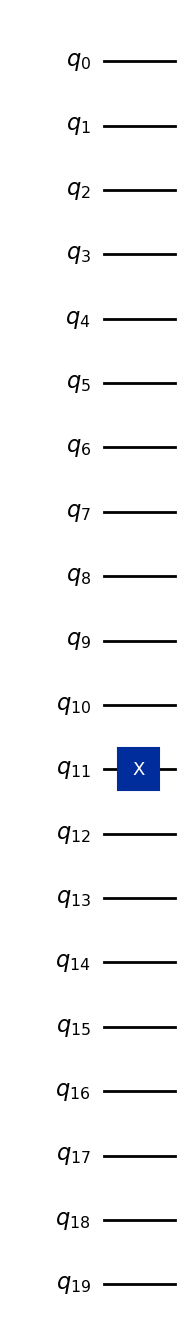

In [6]:
qc_state_prep = QuantumCircuit(n_qubits)
qc_state_prep.x(int(n_qubits/2)+1)
qc_state_prep.draw('mpl')

### Time evolution

We can realize the time-evolution operator generated by a given Hamiltonian: $U=e^{-iHt}$ via the [Lie-Trotter approximation](https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.LieTrotter).

In [7]:
t = Parameter('t')

## Create the time-evo op circuit
evol_gate = PauliEvolutionGate(H_op, time=t, synthesis=LieTrotter(reps=num_trotter_steps) )

qr = QuantumRegister(n_qubits)
qc_evol = QuantumCircuit(qr)
qc_evol.append(evol_gate, qargs=qr)

### Hadamard test



\begin{equation}
    |0\rangle_a|\psi_0\rangle\quad\longrightarrow\quad\frac{1}{\sqrt{2}}\Big(|0\rangle+|1\rangle\Big)_a|\psi_0\rangle\quad\longrightarrow\quad\frac{1}{\sqrt{2}}\Big(|0\rangle_a|\psi_0\rangle+|1\rangle_aU_j^\dagger PU_k|\psi_0\rangle\Big)
\end{equation}
Where $P$ is one of the terms in the decomposition of the Hamiltonian $H=\sum P$. To measure $X$, first apply $H$...
\begin{equation}
    \longrightarrow\quad\frac{1}{2}|0\rangle_a\Big(|\psi_0\rangle+U_j^\dagger PU_k|\psi_0\rangle\Big) + \frac{1}{2}|1\rangle_a\Big(|\psi_0\rangle-U_j^\dagger PU_k|\psi_0\rangle\Big)
\end{equation}
... then measure:
\begin{equation}
\begin{split}
    \Rightarrow\quad\langle X\rangle_a &= \frac{1}{4}\Bigg(\Big\||\psi_0\rangle+U_j^\dagger PU_k|\psi_0\rangle\Big\|^2-\Big\||\psi_0\rangle-U_j^\dagger PU_k|\psi_0\rangle\Big\|^2\Bigg) \\
    &= \text{Re}\Big[\langle\psi_0|U_j^\dagger PU_k|\psi_0\rangle\Big].
\end{split}
\end{equation}
Similarly, measuring $Y$ yields
\begin{equation}
    \langle Y\rangle_a = \text{Im}\Big[\langle\psi_0|U_j^\dagger PU_k|\psi_0\rangle\Big].
\end{equation}

Circuit for calculating the real part of the overlap in S via Hadamard test


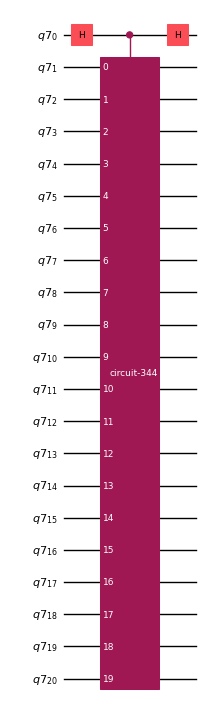

In [8]:
## Create the time-evo op circuit
evol_gate = PauliEvolutionGate(H_op, time=dt, synthesis= LieTrotter(reps=num_trotter_steps) ) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op

## Create the time-evo op dagger circuit
evol_gate_d = PauliEvolutionGate(H_op, time=dt, synthesis= LieTrotter(reps=num_trotter_steps) )
evol_gate_d = evol_gate_d.inverse()

# Put pieces together
qc_reg = QuantumRegister(n_qubits)
qc_temp = QuantumCircuit(qc_reg)
qc_temp.compose(qc_state_prep, inplace=True)
for _ in range(num_trotter_steps):
    qc_temp.append(evol_gate, qargs=qc_reg)
for _ in range(num_trotter_steps):
    qc_temp.append(evol_gate_d, qargs=qc_reg)
qc_temp.compose(qc_state_prep.inverse(), inplace=True)

# Create controlled version of the circuit
controlled_U = qc_temp.to_gate().control(1)

# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits+1)
qc_real = QuantumCircuit(qr)
qc_real.h(0)
qc_real.append(controlled_U, list(range(n_qubits+1)))
qc_real.h(0)

print('Circuit for calculating the real part of the overlap in S via Hadamard test')
qc_real.draw('mpl', fold=-1, scale=0.5)

The Hadamard test circuit can be a deep circuit once we decompose to native gates (which will increase even more if we account for the topology of the device)

In [9]:
print('Number of layers of 2Q operations', qc_real.decompose().decompose().depth(lambda x: x[0].num_qubits == 2))

Number of layers of 2Q operations 79345


## Step 2: Optimize circuits and operators

We can optimize the deep circuits for the Hadamard test that we have obtained by introducing some approximations and relying on some assumption about the model Hamiltonian. For example, consider the following circuit for the Hadamard test:


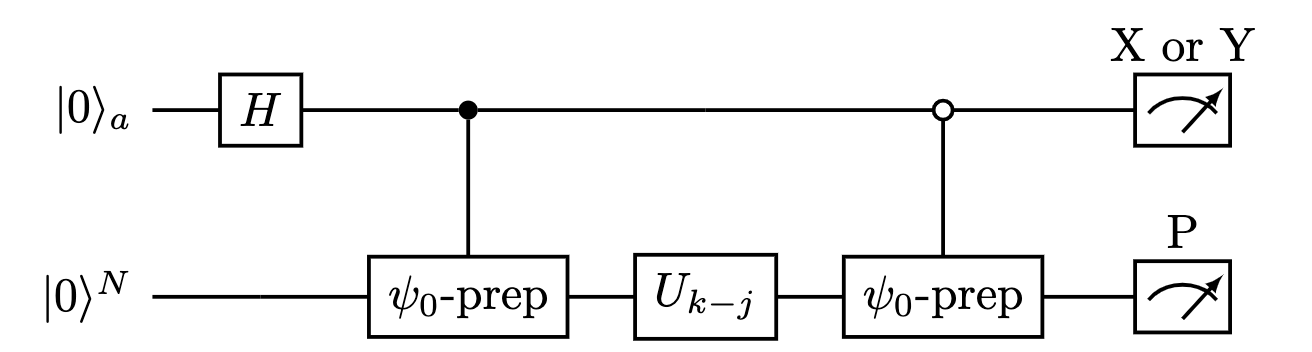

Assume we can classically calculate $E_0$, the eigenvalue of $|0\rangle^N$ under the Hamiltonian $H$.
This is satisfied when the Hamiltonian preserves the U(1) symmetry.
Assume that the gate $\psi_0-prep$ prepares our desired reference state $\ket{\psi_0}$, e.g., to prepare the HF state for chemistry $\psi_0-prep$ would be a product of single-qubit NOTs, so controlled-$\psi_0-prep$ is just a product of CNOTs.
Then the circuit above implements the following state prior to measurement:

\begin{equation}
\begin{split}
    \ket{0} \ket{0}^N\xrightarrow{H}&\frac{1}{\sqrt{2}}
    \left(
    \ket{0}\ket{0}^N+ \ket{1} \ket{0}^N
    \right)\\
    \xrightarrow{\text{1-ctrl-init}}&\frac{1}{\sqrt{2}}\left(|0\rangle|0\rangle^N+|1\rangle|\psi_0\rangle\right)\\
    \xrightarrow{U}&\frac{1}{\sqrt{2}}\left(e^{i\phi}\ket{0}\ket{0}^N+\ket{1} U\ket{\psi_0}\right)\\
    \xrightarrow{\text{0-ctrl-init}}&\frac{1}{\sqrt{2}}
    \left(
    e^{i\phi}\ket{0} \ket{\psi_0}
    +\ket{1} U\ket{\psi_0}
    \right)\\
    =&\frac{1}{2}
    \left(
    \ket{+}\left(e^{i\phi}\ket{\psi_0}+U\ket{\psi_0}\right)
    +\ket{-}\left(e^{i\phi}\ket{\psi_0}-U\ket{\psi_0}\right)
    \right)\\
    =&\frac{1}{2}
    \left(
    \ket{+i}\left(e^{i\phi}\ket{\psi_0}-iU\ket{\psi_0}\right)
    +\ket{-i}\left(e^{i\phi}\ket{\psi_0}+iU\ket{\psi_0}\right)
    \right)
\end{split}
\end{equation}

where we have used the classical simulable phase shift $ U\ket{0}^N = e^{i\phi}\ket{0}$ in the third line. Therefore the expectation values are obtained as

\begin{equation}
\begin{split}
    \langle X\otimes P\rangle&=\frac{1}{4}
    \Big(
    \left(e^{-i\phi}\bra{\psi_0}+\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}+U\ket{\psi_0}\right)
    \\
    &\qquad-\left(e^{-i\phi}\bra{\psi_0}-\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}-U\ket{\psi_0}\right)
    \Big)\\
    &=\text{Re}\left[e^{-i\phi}\bra{\psi_0}PU\ket{\psi_0}\right],
\end{split}
\end{equation}

\begin{equation}
\begin{split}
    \langle Y\otimes P\rangle&=\frac{1}{4}
    \Big(
    \left(e^{-i\phi}\bra{\psi_0}+i\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}-iU\ket{\psi_0}\right)
    \\
    &\qquad-\left(e^{-i\phi}\bra{\psi_0}-i\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}+iU\ket{\psi_0}\right)
    \Big)\\
    &=\text{Im}\left[e^{-i\phi}\bra{\psi_0}PU\ket{\psi_0}\right].
\end{split}
\end{equation}


### Decompose time-evolution operator with Lie-Trotter decomposition
Instead of implementing the time-evolution operator exactly we can use the Lie-Trotter decomposition to implement an approximation of it. Repeating several times a certain order Trotter decomposition gives us further reduction of the error introduced from the approximation. In the following, we directly build the Trotter implementation in the most efficient way for the interaction graph of the Hamiltonian we are considering (nearest neighbor interactions only). In practice we insert Pauli rotations $R_{xx}$, $R_{yy}$, $R_{zz}$ with a parametrized angle $t$ which correspond to the approximate implementation of $e^{-i (XX + YY + ZZ) t}$. Given the difference in definition of the Pauli rotations and the time-evolution that we are trying to implement, we'll have to use the parameter $2*dt$ to achieve a time-evolution of $dt$.  This gives a much shallower circuit than what is obtained using the generic `PauliEvolutionGate()` functionality. 

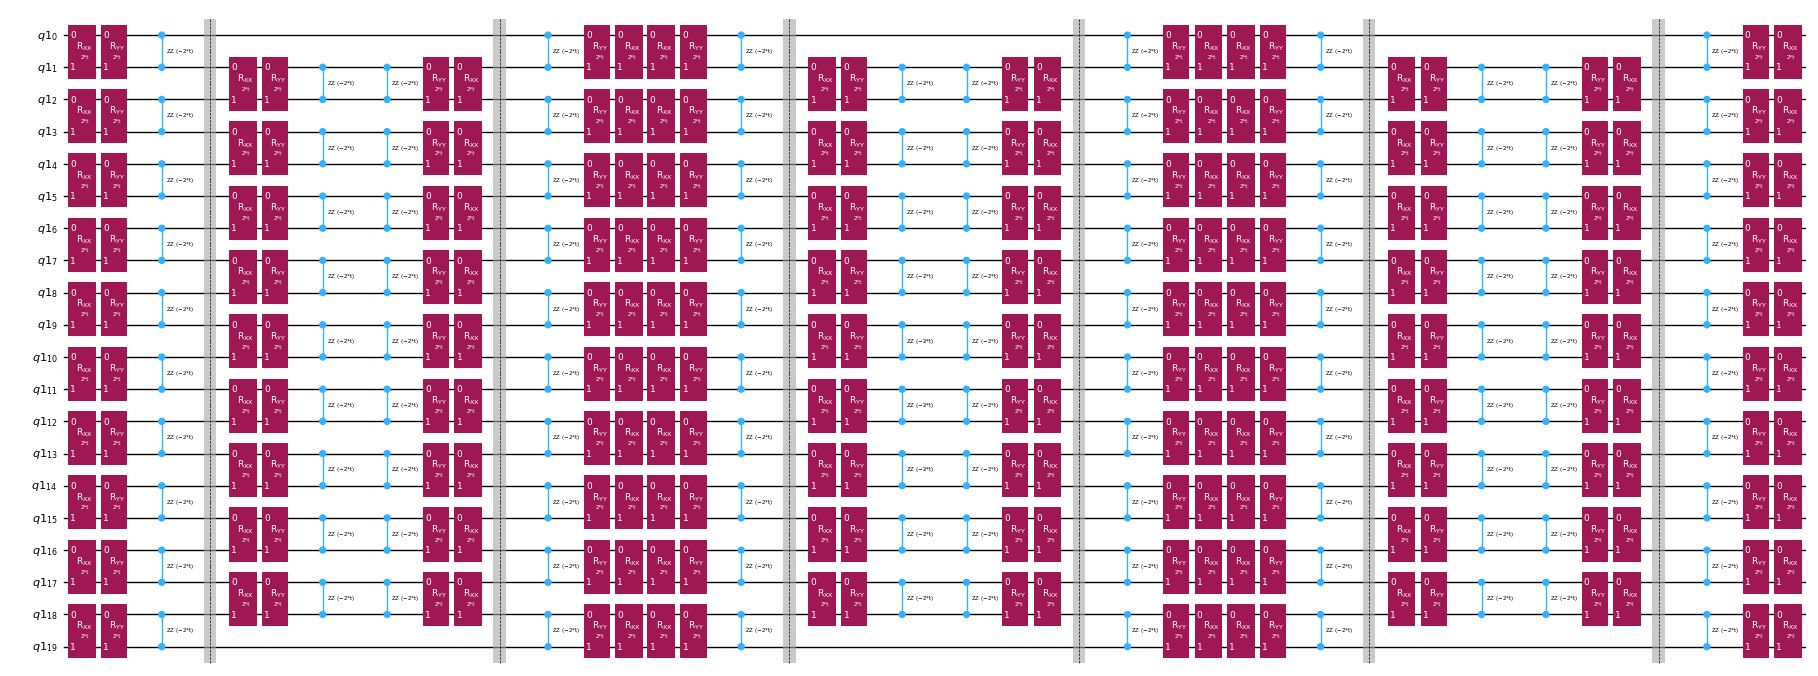

In [9]:
t = Parameter('t')

# Create instruction for rotation about XX+YY-ZZ:
Rxyz_circ = QuantumCircuit(2)
Rxyz_circ.rxx(2*t,0,1)
Rxyz_circ.ryy(2*t,0,1)
Rxyz_circ.rzz(-2*t,0,1)
Rxyz_instr = Rxyz_circ.to_instruction(label='RXX+YY-ZZ')

interaction_list = [[[i, i+1] for i in range(0, n_qubits-1, 2)], [[i, i+1] for i in range(1, n_qubits-1, 2)]] # linear chain

qr = QuantumRegister(n_qubits)
trotter_step_circ = QuantumCircuit(qr)
for i, color in enumerate(interaction_list):
    for interaction in color:
        trotter_step_circ.append(Rxyz_instr, interaction)
    if i < len(interaction_list) -1:
        trotter_step_circ.barrier()
    # trotter_step_circ.barrier()
reverse_trotter_step_circ = trotter_step_circ.reverse_ops()

qc_evol = QuantumCircuit(qr)
for step in range(num_trotter_steps):
    if step % 2 == 0:
        qc_evol = qc_evol.compose(trotter_step_circ)
    else:
        qc_evol = qc_evol.compose(reverse_trotter_step_circ)
        # qc_evol = qc_evol.compose(trotter_step_circ)

qc_evol.decompose().draw('mpl', fold=-1, scale = 0.5)

### Use an optimized circuit for state preparation

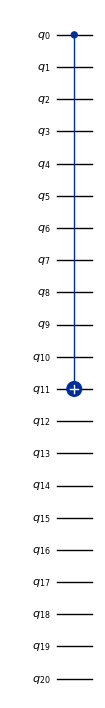

In [10]:
control = 0
excitation = int(n_qubits/2)+1
controlled_state_prep = QuantumCircuit(n_qubits + 1)
controlled_state_prep.cx(control, excitation)
controlled_state_prep.draw('mpl', fold=-1, scale=0.5)


controlled_state_prep.draw('mpl', fold=-1, scale=0.5)

### Template circuits for calculating matrix elements of $\tilde{S}$ and $\tilde{H}$ via Hadamard test
The only difference between the circuits used in the Hadamard test will be the phase in the time-evolution operator and the observables measured. Therefore we can prepare a template circuit which represent the generic circuit for the Hadamard test, with placeholders for the gates that depend on the time-evolution operator.

In [11]:
# Parameters for the template circuits
parameters = []
for idx in range(1, krylov_dim):
    parameters.append(dt_circ*(idx))

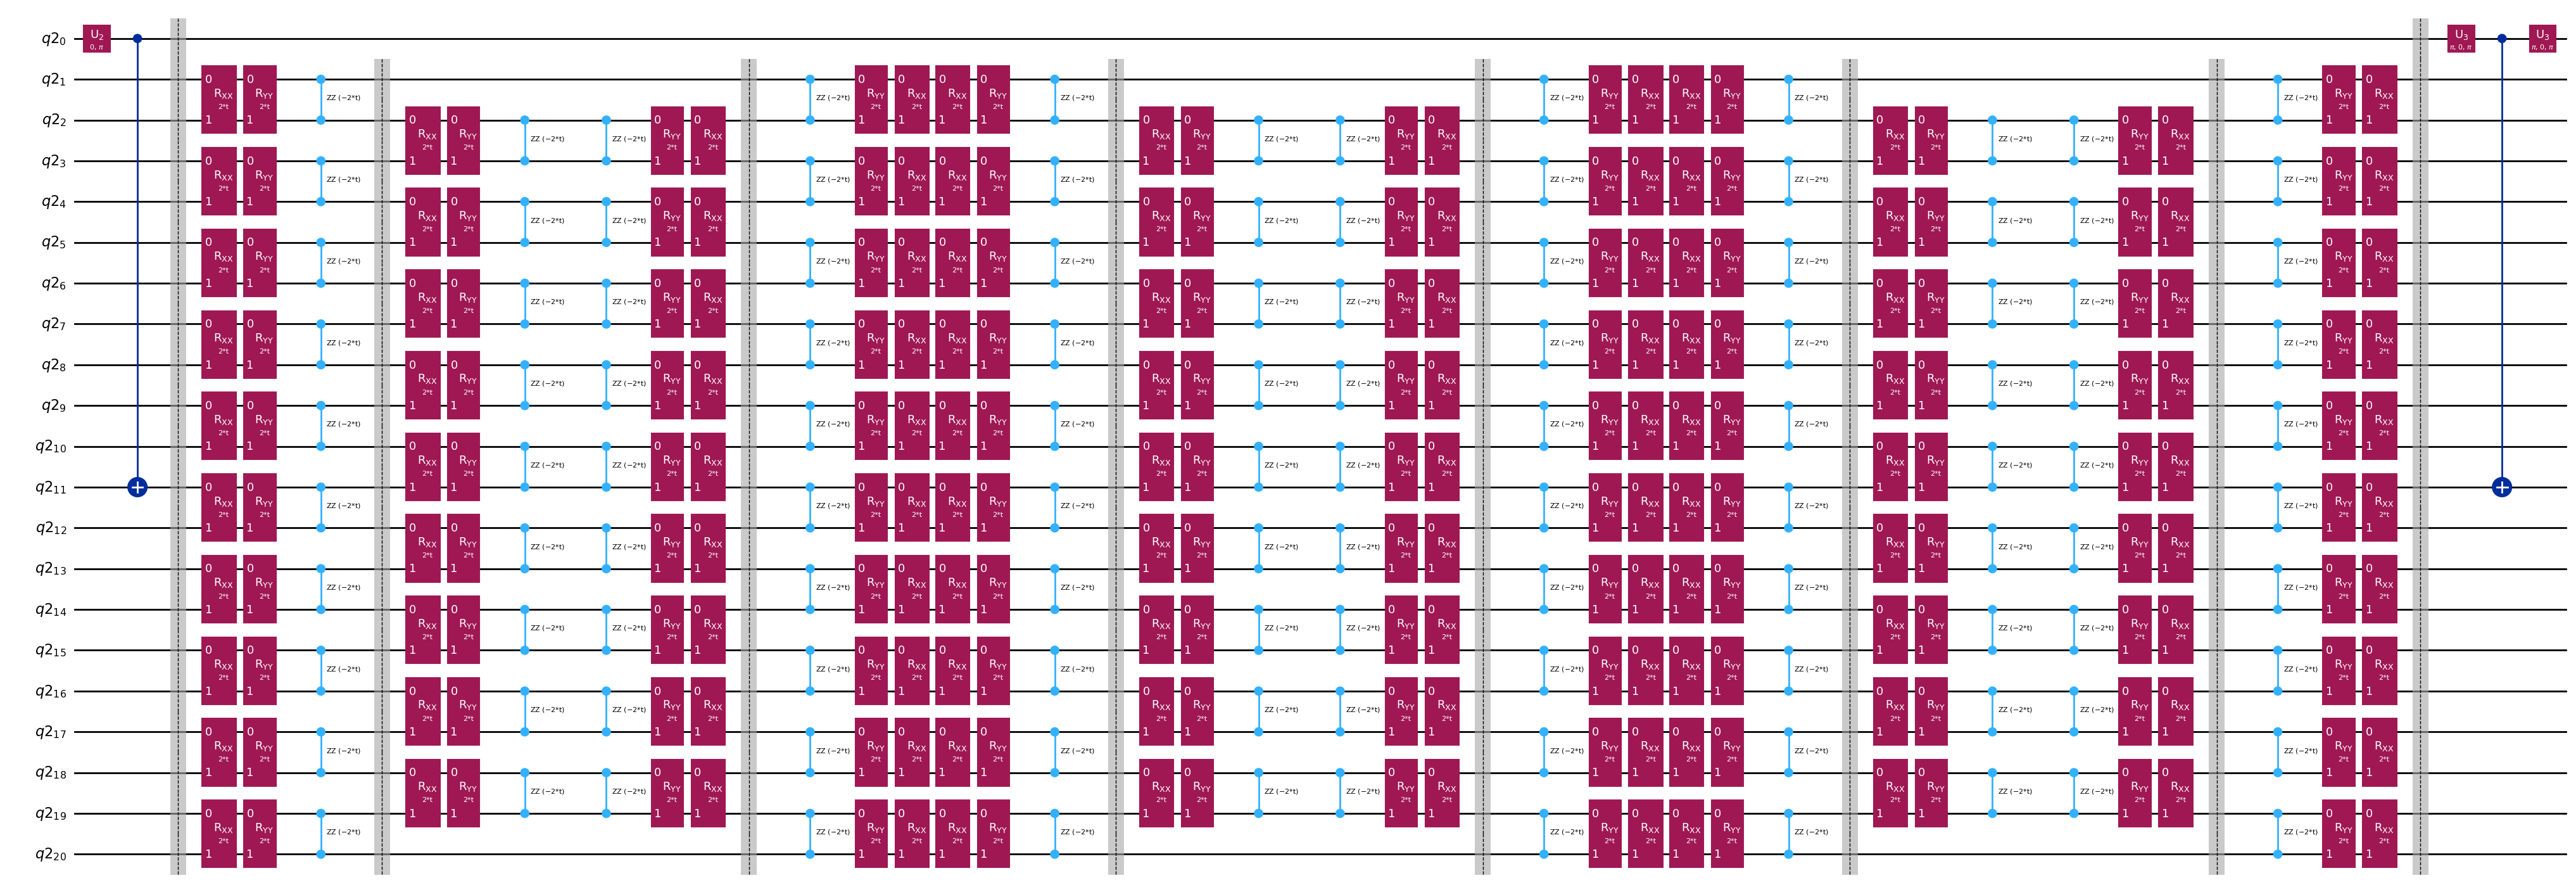

In [12]:
# Create modified hadamard test circuit
qr = QuantumRegister(n_qubits+1)
qc = QuantumCircuit(qr)
qc.h(0)
qc.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc.barrier()
qc.compose(qc_evol, list(range(1, n_qubits+1)), inplace=True)
qc.barrier()
qc.x(0)
qc.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc.x(0)

qc.decompose().draw('mpl', fold=-1)

In [13]:
print('The optimized circuit has 2Q gates depth: ', qc.decompose().decompose().depth(lambda x: x[0].num_qubits ==2))

The optimized circuit has 2Q gates depth:  74


We have considerably reduced the depth of the Hadamard test with a combination of Trotter approximation and uncontrolled unitaries

## Step 3: Execute using a quantum primitive

Instantiate the backend and set runtime parameters

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeGuadalupeV2
from qiskit_aer import AerSimulator


SIM = False
NOISE = False
# service = QiskitRuntimeService(instance='ibm-q-internal/technical-enable/utokyol3enableme')#
# service = QiskitRuntimeService(name="staging", instance='ibm-q-internal/internal-test/fast-flux')
# service = QiskitRuntimeService(instance='client-enablement/solutionsnoteboo/krylov-utility-d')
service = QiskitRuntimeService(instance='client-enablement/solutions/demo-testing')

# # IBMQ.load_account()
# provider = IBMProvider(name="staging")
# backend = provider.get_backend('ibm_montecarlo')
# cmap_gen = GateDirection(backend=backend).coupling_map
# coupling_map = list(cmap_gen.get_edges())
# coupling_map = [tuple(pair) for pair in coupling_map]


if SIM:
    # backend = service.least_busy(simulator=True)
    
    if NOISE:
        backend = AerSimulator.from_backend(FakeGuadalupeV2(), seed_simulator=42)

    else:
        backend = AerSimulator()

else:
    # backend_id = 'ibm_pinguino1'
    backend_id = 'ibm_torino'
    # backend_id = 'ibm_montecarlo'
    # backend_id = 'ibm_kyiv'
    backend = service.backend(backend_id)

shots = 50000


### Transpile

In [15]:
phys_system_qubits = (list(range(1,13)) + [18] + [31,30,29] + [36] + [48,47,46] + [55] + list(range(57,66))[::-1])[:20]
phys_control_qubit = [13]
# phys_system_qubits = (list(range(1,9)) + [17] + [27,28,29] + [36] + [48,47,46] + [55] + list(range(57,66))[::-1])[:20]
# phys_control_qubit = [30]
phys_qubits = phys_control_qubit + phys_system_qubits
phys_qubit_excitation = phys_qubits[excitation]
phys_qubit_excitation

11

In [16]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


if not SIM or (SIM and NOISE):
    target = backend.target
    basis_gates = list(target.operation_names)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, basis_gates=basis_gates, initial_layout=phys_qubits)

    qc_trans = pm.run(qc)

In [17]:
print(qc_trans.depth(lambda x: x[0].num_qubits==2))
print(qc_trans.count_ops())
qc_trans.draw('mpl', fold=-1, idle_wires=False, scale=2)


61
OrderedDict([('rz', 1803), ('sx', 1150), ('cz', 487), ('x', 69), ('barrier', 8)])


### Create PUBs for execution with Estimator

In [18]:
# Define observables to measure for S
observable_S_real = 'I'*(n_qubits) + 'X'
observable_S_imag = 'I'*(n_qubits) + 'Y'

if not SIM or (SIM and NOISE):

    layout = qc_trans.layout # get layout of transpiled circuit

    observable_op_real = SparsePauliOp(observable_S_real) # define a sparse pauli operator for the observable
    observable_op_imag = SparsePauliOp(observable_S_imag)
    observable_op_real = observable_op_real.apply_layout(layout) # apply physical layout to the observable
    observable_op_imag = observable_op_imag.apply_layout(layout)
    observable_S_real = observable_op_real.paulis.to_labels() # get the label of the physical observable
    observable_S_imag = observable_op_imag.paulis.to_labels() 


# Define a set of observables to measure
# else:
    # observable = [observable_S_real, observable_S_imag]

observables_S = [[observable_S_real], [observable_S_imag]]

# Define a sweep over parameter values
params = np.vstack(parameters).T


# Define observables to measure for H
# Hamiltonian terms to measure
observable_list = []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    # print(pauli)
    observable_H_real = pauli[::-1].to_label() + 'X'
    observable_H_imag = pauli[::-1].to_label() + 'Y'
    observable_list.append([observable_H_real])
    observable_list.append([observable_H_imag])


if not SIM or (SIM and NOISE):

    layout = qc_trans.layout

    observable_trans_list = []
    for observable in observable_list:
        observable_op = SparsePauliOp(observable)
        observable_op = observable_op.apply_layout(layout)
        observable_trans_list.append([observable_op.paulis.to_labels()])

    observable_list = observable_trans_list


observables_H = observable_list



# Estimate the expectation value for all combinations of
# observables and parameter values, where the pub result will have
# shape (# observables, # parameter values).
if not SIM or (SIM and NOISE):
    pub = (qc_trans, observables_S + observables_H, params)

else:
    pub = (qc.decompose(), observables_S + observables_H, params)



## Run circuits
Circuits for $t=0$ are classically calculable

In [19]:
from qiskit.quantum_info import StabilizerState, Pauli



qc_cliff = qc.assign_parameters({t:0})

# observables_H_real_cliff = []
# observables_H_imag_cliff = []
# for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
#     # print(pauli)
#     observable_real = pauli[::-1].to_label() + 'X'
#     observable_imag = pauli[::-1].to_label() + 'Y'
#     observables_H_real_cliff.append(observable_real)
#     observables_H_imag_cliff.append(observable_imag)



# Get expectation values from experiment
S_expval_real = StabilizerState(qc_cliff).expectation_value(Pauli('I'*(n_qubits) + 'X'))
S_expval_imag = StabilizerState(qc_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Y'))

# Get expectation values
S_expval = S_expval_real + 1j*S_expval_imag

H_expval = 0
for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Get expectation values from experiment
    expval_real = StabilizerState(qc_cliff).expectation_value(Pauli(pauli[::-1].to_label() + 'X'))
    expval_imag = StabilizerState(qc_cliff).expectation_value(Pauli(pauli[::-1].to_label() + 'Y'))
    expval = expval_real + 1j*expval_imag


    # Fill-in matrix elements
    H_expval += coeff*expval


H_expval

(-15+0j)

Execute circuits for $\tilde{S}$ and $\tilde{H}$ with the Estimator

In [20]:
# from pec_runtime.primitives import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorV2 as Estimator

LOAD = True

if LOAD:
    #good 20q 5dim: ctnza5r4gjh0008pkhhg
    loaded_job_id = 'ctnza5r4gjh0008pkhhg'
    job = service.job(loaded_job_id)
else:
    if SIM:
        with Session(backend=backend) as session:
            estimator = Estimator(session=session)
            job = estimator.run([pub], precision=1/np.sqrt(shots))
    else:

        # Experiment options
        num_randomizations = 300
        num_randomizations_learning = 20
        max_batch_circuits = 20
        shots_per_randomization = 100
        learning_pair_depths = [0, 4, 24]
        noise_factors = [1, 1.3, 1.6]

        # Base option formatting
        options = {
            # Builtin resilience settings for ZNE
            "resilience": {
                "measure_mitigation": True,
                "zne_mitigation": True,
                "zne": {"noise_factors": noise_factors},

                # TREX noise learning configuration
                "measure_noise_learning": {
                    "num_randomizations": num_randomizations_learning,
                    "shots_per_randomization": shots_per_randomization,
                },
                
                # PEA noise model configuration
                "layer_noise_learning": {
                    "max_layers_to_learn": 10,
                    "layer_pair_depths": learning_pair_depths,
                    "shots_per_randomization": shots_per_randomization,
                    "num_randomizations": num_randomizations_learning,
                },
            },
            
            # Randomization configuration
            "twirling": {
                "num_randomizations": num_randomizations,
                "shots_per_randomization": shots_per_randomization,
                "strategy": "all",
            },

            # Experimental settings for PEA method
            "experimental": {
                # # Just in case, disable any further qiskit transpilation not related to twirling / DD
                # "skip_transpilation": True,

                # Execution configuration
                "execution": {
                    "max_pubs_per_batch_job": max_batch_circuits,
                    "fast_parametric_update": True,
                },

                # Error Mitigation configuration
                "resilience": {
                    # ZNE Configuration
                    "zne": {
                        "amplifier": "pea",
                        "return_all_extrapolated": True,
                        "return_unextrapolated": True,
                        "extrapolated_noise_factors": [0] + noise_factors,
                    }
                }
            }
        }

        with Batch(backend=backend) as batch:
            # Estimator
            estimator = Estimator(session=batch, options=options)

            # # estimator.options.default_shots = 3000

            # # twirling
            # estimator.options.twirling.shots_per_randomization = 100
            # estimator.options.twirling.num_randomizations = 500
            # estimator.options.twirling.strategy = 'all'

            # DD
            # estimator.options.dynamical_decoupling.enable = True
            # estimator.options.dynamical_decoupling.sequence_type = 'XpXm'


            # Additional options to enable and modify PEA based ZNE
            # estimator.options.resilience.zne.amplifier = "pea"
            estimator.options.resilience.zne.noise_factors = noise_factors

            # #trex
            # estimator.options.resilience.measure_noise_learning.num_randomizations = 100
            # estimator.options.resilience.measure_noise_learning.shots_per_randomization = 100

            # #pea learning
            # estimator.options.resilience.layer_noise_learning.layer_pair_depths = [0, 4, 24]
            # estimator.options.resilience.layer_noise_learning.shots_per_randomization = 100
            # estimator.options.resilience.layer_noise_learning.num_randomizations = 15

            # # experimental options
            # estimator.options.experimental.execution.fast_parametric_update = True
            # estimator.options.experimental.resilience.zne.amplifier = 'pea'
            # estimator.options.experimental.resilience.zne.return_all_extrapolated = True
            # estimator.options.experimental.resilience.zne.return_unextrapolated = True
            # estimator.options.experimental.resilience.zne.extrapolated_noise_factors = [1, 1.3, 1.6]


            job = estimator.run([pub], precision=1)


In [21]:
job_id = job.job_id()

print(job_id)

ctnza5r4gjh0008pkhhg


## Step 4: Post-process and analyze results

In [22]:
results = job.result()[0]

### Calculate projected $\tilde{H}$ and $S$ matrices
First calculate the phase accumulated by the |0> state during the uncontrolled time evolution

In [23]:
prefactors = [np.exp(-1j*sum([c for p,c in H_op.to_list() if 'Z' in p])*i*dt) for i in range(1, krylov_dim)]

Once we have the results of the circuit executions we can post-process the data to calculate the matrix elements of $\tilde{S}$

In [24]:
# Assemble S, the overlap matrix of dimension D:
S_first_row = np.zeros(krylov_dim, dtype=complex)
S_first_row[0] = 1+0j

# Add in ancilla-only measurements:
for i in range(krylov_dim-1):

    # Get expectation values from experiment
    expval_real = results.data.evs[0][0][i] # automatic extrapolated evs if ZNE is used
    expval_imag = results.data.evs[1][0][i] # automatic extrapolated evs if ZNE is used

    # Get expectation values
    expval = expval_real + 1j*expval_imag
    # Get the coefficients and expectation values corresponding to actual terms in the Hamiltonian (as opposed to the ancilla-only measurements).
    S_first_row[i+1] += prefactors[i]*expval

S_first_row_list =  S_first_row.tolist() #for saving purposes     
            
            
S_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in it.product(range(krylov_dim),repeat=2):
    if i >= j:
        S_circ[j,i] = S_first_row[i-j]
    else:
        S_circ[j,i] = np.conj(S_first_row[j-i])

In [25]:
from sympy import Matrix
Matrix(S_circ)

Matrix([
[                                        1.0,   -0.196434913889163 + 0.0500383940919276*I, 0.0546016995581735 - 0.0505379338507588*I, -0.00387682750070485 + 0.0422688947676071*I,  0.0153832239760824 - 0.00302755483851761*I],
[  -0.196434913889163 - 0.0500383940919276*I,                                         1.0, -0.196434913889163 + 0.0500383940919276*I,   0.0546016995581735 - 0.0505379338507588*I, -0.00387682750070485 + 0.0422688947676071*I],
[  0.0546016995581735 + 0.0505379338507588*I,   -0.196434913889163 - 0.0500383940919276*I,                                       1.0,   -0.196434913889163 + 0.0500383940919276*I,   0.0546016995581735 - 0.0505379338507588*I],
[-0.00387682750070485 - 0.0422688947676071*I,   0.0546016995581735 + 0.0505379338507588*I, -0.196434913889163 - 0.0500383940919276*I,                                         1.0,   -0.196434913889163 + 0.0500383940919276*I],
[ 0.0153832239760824 + 0.00302755483851761*I, -0.00387682750070485 - 0.0422688947676071*I, 

And the matrix elements of $\tilde{H}$

In [26]:
import itertools
# Assemble S, the overlap matrix of dimension D:
H_first_row = np.zeros(krylov_dim, dtype=complex)
H_first_row[0] = H_expval

for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Add in ancilla-only measurements:
    for i in range(krylov_dim-1):

        # Get expectation values from experiment
        expval_real = results.data.evs[2 + 2*obs_idx][0][i] # automatic extrapolated evs if ZNE is used
        expval_imag = results.data.evs[2 + 2*obs_idx + 1][0][i] # automatic extrapolated evs if ZNE is used

        # Get expectation values
        expval = expval_real + 1j*expval_imag
        # Get the coefficients and expectation values corresponding to actual terms in the Hamiltonian (as opposed to the ancilla-only measurements).
        H_first_row[i+1] += prefactors[i]*coeff*expval
        
H_first_row_list = H_first_row.tolist()           
            
H_eff_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ[j,i] = H_first_row[i-j]
    else:
        H_eff_circ[j,i] = np.conj(H_first_row[j-i])



In [27]:
from sympy import Matrix
Matrix(H_eff_circ)

Matrix([
[                                   -15.0,   1.18720067378867 - 0.502314783745159*I, -0.567367191944345 + 0.377743288891421*I,  0.385971096063646 - 0.130802525438685*I, -0.457985312690567 + 0.302191303190108*I],
[  1.18720067378867 + 0.502314783745159*I,                                    -15.0,   1.18720067378867 - 0.502314783745159*I, -0.567367191944345 + 0.377743288891421*I,  0.385971096063646 - 0.130802525438685*I],
[-0.567367191944345 - 0.377743288891421*I,   1.18720067378867 + 0.502314783745159*I,                                    -15.0,   1.18720067378867 - 0.502314783745159*I, -0.567367191944345 + 0.377743288891421*I],
[ 0.385971096063646 + 0.130802525438685*I, -0.567367191944345 - 0.377743288891421*I,   1.18720067378867 + 0.502314783745159*I,                                    -15.0,   1.18720067378867 - 0.502314783745159*I],
[-0.457985312690567 - 0.302191303190108*I,  0.385971096063646 + 0.130802525438685*I, -0.567367191944345 - 0.377743288891421*I,   1.187200673788

Finally, we can solve the generalized eigenvalue problem for $\tilde{H}$:

$$\tilde{H} \vec{c} = c \tilde{S} \vec{c}$$

and get an estimate of the ground state energy $c_{min}$

In [28]:
gnd_en_circ_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ[:d, :d], S_circ[:d, :d], threshold=1e-1)
    gnd_en_circ_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  -15.0
The estimated ground state energy is:  -17.225793064472
The estimated ground state energy is:  -18.16187881765736
The estimated ground state energy is:  -18.5176173738637
The estimated ground state energy is:  -18.78640656528519


For a single-particle sector, we can efficiently calculate the ground state of this sector of the Hamiltonian classically

In [29]:
gs_en = single_particle_gs(H_op, n_qubits)

n_sys_qubits 20
n_exc 1 , subspace dimension 21
single particle ground state energy:  -19.0


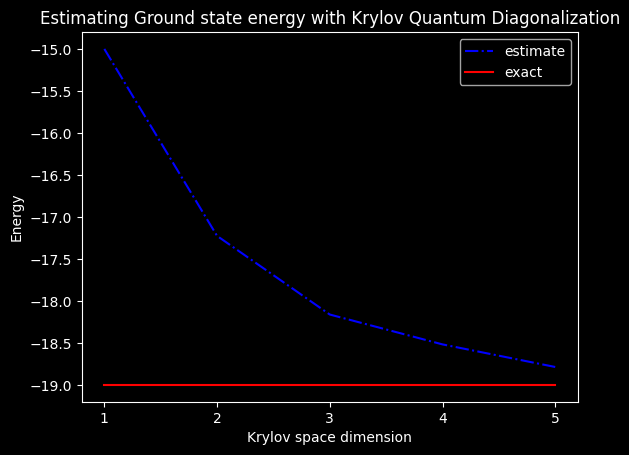

In [31]:
plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list, color = 'blue', linestyle='-.' , label = 'estimate')
plt.plot(range(1, krylov_dim+1), [gs_en]*krylov_dim, color = 'red', linestyle='-' , label = 'exact')
plt.xticks(range(1, krylov_dim+1), range(1, krylov_dim+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Krylov Quantum Diagonalization')
plt.show()